## Modeling with logistic regression

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.compose import  ColumnTransformer, make_column_transformer

from nltk.corpus import stopwords 
from bs4 import BeautifulSoup
import string
import regex as re


Bad key "text.kerning_factor" on line 4 in
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%store -r combined

In [3]:
combined.head(2)

,title,selftext,subreddit,title_selftext
0,With all this stimulus- why is bitcoin acting ...,,1,With all this stimulus- why is bitcoin acting ...
1,Abra Wallet,Is abra wallet a good place to store bitcoin i...,1,Abra Wallet Is abra wallet a good place to sto...


In [4]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    stops.update(list(string.punctuation))
#     words_add = ['removed', 'http', 'startup', 'startups', 'streaming']
#     stops.update(list(words_add))

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [5]:
combined['cleaned'] = combined.title_selftext.map(review_to_words)

In [6]:
combined.head(2)

,title,selftext,subreddit,title_selftext,cleaned
0,With all this stimulus- why is bitcoin acting ...,,1,With all this stimulus- why is bitcoin acting ...,stimulus bitcoin acting like markets
1,Abra Wallet,Is abra wallet a good place to store bitcoin i...,1,Abra Wallet Is abra wallet a good place to sto...,abra wallet abra wallet good place store bitco...


In [7]:
#baseline model
combined['subreddit'].value_counts(normalize = True)

1    0.631338
0    0.368662
Name: subreddit, dtype: float64

In [8]:
#set X and y variables
X = combined[['cleaned']]
y = combined['subreddit']

### Train/test/split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify = y, random_state = 42)

In [10]:
y_test.value_counts(normalize = True)

1    0.631373
0    0.368627
Name: subreddit, dtype: float64

**lemmatokenizer**

In [11]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [12]:
col_transformer_cv = make_column_transformer(
  (CountVectorizer(tokenizer = LemmaTokenizer()), 'cleaned'),
  remainder = 'passthrough'
)
col_transformer_td = make_column_transformer(
  (TfidfVectorizer(tokenizer = LemmaTokenizer()), 'cleaned'),
  remainder = 'passthrough'
)
pipe_lr_cv = Pipeline([
    ("col_trans", col_transformer_cv),
    ("log_reg", LogisticRegression(solver = "liblinear"))])

pipe_lr_td = Pipeline([
    ("col_trans", col_transformer_td),
    ("log_reg", LogisticRegression(solver = "liblinear"))])
    
# Construct Grid Parameters for CountVectorizer
hyperparams_cv = {
               'col_trans__countvectorizer__ngram_range': [(1,1), (1,2)],
               'col_trans__countvectorizer__stop_words': [None,'english'],
               'col_trans__countvectorizer__max_features': [None, 100, 500,1000],
               'col_trans__countvectorizer__min_df': [1, 3, 4],
               'col_trans__countvectorizer__max_df': [0.9, 0.95, .9],
#                 'logreg__C': [1, 5, 100],
#                 'logreg__penalty' : ['l1','l2']
                 }
# Construct Grid Parameters for TDIDFFVectorizer
hyperparams_td = {'col_trans__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
               'col_trans__tfidfvectorizer__stop_words': [None, 'english'],
               'col_trans__tfidfvectorizer__max_features': [None, 100, 500,1000],
               'col_trans__tfidfvectorizer__min_df': [1, 3, 4],
               'col_trans__tfidfvectorizer__max_df': [0.9, 0.95, .99]
                 }

**Logisticregression & countvectorizer**

In [13]:
gs_lr_cv = GridSearchCV(pipe_lr_cv, param_grid=hyperparams_cv, verbose=1,cv=5,n_jobs=4)
gs_lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  3.3min finished
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('col_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('countvectorizer',
                                                                         CountVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.int64'>,
                 

In [14]:
print(f'Train score: {gs_lr_cv.score(X_train, y_train)}')
print(f'Test score: {gs_lr_cv.score(X_test, y_test)}')

Train score: 0.9777486910994765
Test score: 0.8954248366013072


In [15]:
#best parameters
gs_lr_cv.best_params_

{'col_trans__countvectorizer__max_df': 0.9,
 'col_trans__countvectorizer__max_features': None,
 'col_trans__countvectorizer__min_df': 3,
 'col_trans__countvectorizer__ngram_range': (1, 2),
 'col_trans__countvectorizer__stop_words': 'english'}

In [16]:
feat_names = gs_lr_cv.best_estimator_.named_steps['col_trans'].get_feature_names()
feat_names = [i.replace('countvectorizer__', '') for i in feat_names]
feat_names

['aa',
 'ab',
 'abc',
 'ability',
 'able',
 'able buy',
 'able help',
 'able sell',
 'able use',
 'absolutely',
 'abstract',
 'ac',
 'academic',
 'accept',
 'accept bitcoin',
 'accept btc',
 'accept crypto',
 'acceptance',
 'accepted',
 'accepting',
 'accepting bitcoin',
 'accepting btc',
 'accepting crypto',
 'accepts',
 'access',
 'access account',
 'access wallet',
 'accessible',
 'accessing',
 'accidentally',
 'according',
 'account',
 'account bitcoin',
 'account got',
 'account http',
 'account need',
 'account removed',
 'accumulating',
 'accurate',
 'achieve',
 'achieved',
 'acquire',
 'acquired',
 'acquisition',
 'act',
 'acting',
 'action',
 'activate',
 'activated',
 'active',
 'active community',
 'actively',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'ad f',
 'add',
 'added',
 'added block',
 'addictive',
 'adding',
 'addition',
 'additional',
 'address',
 'address ethereum',
 'address http',
 'address like',
 'address multiple',
 'address removed',
 'address s

In [17]:
coefs = gs_lr_cv.best_estimator_.named_steps['log_reg'].coef_
coefs = coefs.tolist()
coefs[0]

[0.01832025990566492,
 -0.10820373371476737,
 9.96783502078178e-05,
 -0.12316068104066773,
 0.08686366110745126,
 0.00046028754788431515,
 0.021049804591290838,
 -9.33069111217789e-05,
 -0.05736257021136908,
 0.002059022096532502,
 0.0006871973239678063,
 0.051195022126162254,
 0.04164790972544565,
 0.5628368716779144,
 0.00023191586312035196,
 0.022395868793352217,
 0.0039717304656021035,
 0.0011026193675102386,
 -0.010979590990291612,
 -0.3085124549670583,
 0.0011892446689263524,
 0.021801379521319615,
 -0.2544942403457355,
 -1.5978111156114154e-06,
 -0.11439556910891432,
 -0.002333741025125949,
 0.024598688156724727,
 -0.10526060679589071,
 -0.09260672838371488,
 -0.02036154552817447,
 -0.10393367839164212,
 0.15719223416920086,
 8.129490451435552e-05,
 -0.7840173553892393,
 0.0010769550485334027,
 0.060573701205458116,
 -0.2166583594054789,
 0.07181848852599185,
 -0.04013285849723487,
 0.00210639200400277,
 0.033935098964742075,
 0.06974187148660302,
 0.07157621787984147,
 0.044068

In [18]:
data = {'names': feat_names, 'coefs': np.round(coefs[0], 3)}
df = pd.DataFrame(data)
df

,names,coefs
0,aa,0.018
1,ab,-0.108
2,abc,0.000
3,ability,-0.123
4,able,0.087
...,...,...
4597,z,0.126
4598,zap,0.027
4599,zendesk,-0.026
4600,zero,0.159


In [19]:
gs_lr_cv.best_estimator_.steps[0][1].fit_transform(X_train).toarray()

/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]])

In [20]:
gs_lr_cv.best_estimator_.steps[0][1].transform(X_test).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
df1 = pd.DataFrame(gs_lr_cv.best_estimator_.steps[0][1].transform(X_test).toarray(), columns =
             feat_names)

In [22]:
df1

,aa,ab,abc,ability,able,able buy,able help,able sell,able use,absolutely,...,youtube,youtube channel,youtube com,youtuber,yr,z,zap,zendesk,zero,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
preds = gs_lr_cv.predict(X_test)
preds

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,

In [32]:
# df1.loc[df1['preds'] == 1].sum().sort_values(ascending=False)
df1['preds'] = preds
df1.head()

,aa,ab,abc,ability,able,able buy,able help,able sell,able use,absolutely,...,youtube channel,youtube com,youtuber,yr,z,zap,zendesk,zero,zoom,preds
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df1.loc[df1['preds']==0].sum()

aa         5
ab         4
abc        0
ability    4
able       5
          ..
zap        0
zendesk    0
zero       2
zoom       0
preds      0
Length: 4603, dtype: int64

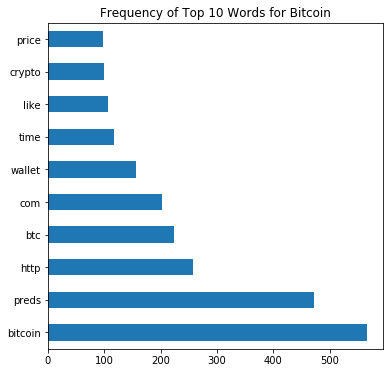

In [38]:
plt.figure(figsize = (6,6))
df1.loc[df1['preds'] == 1].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Bitcoin')
plt.ylabel("")
plt.show()

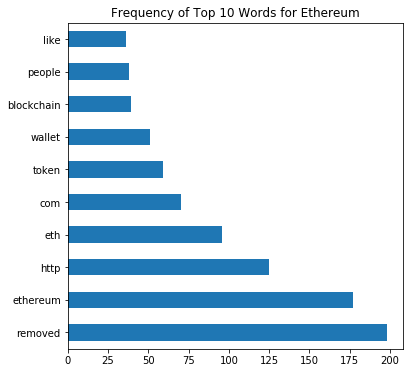

In [39]:
plt.figure(figsize = (6,6))
df1.loc[df1['preds'] == 0].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Ethereum')
plt.ylabel("")
plt.show()

In [40]:
#confusion Matrix
pred_y_cv = gs_lr_cv.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred_y_cv), 
             columns=['predict_bitcoin', 'predict_ethereum'], 
             index=['actual_bitcoin', 'actual_ethereum'])

,predict_bitcoin,predict_ethereum
actual_bitcoin,247,35
actual_ethereum,45,438


**Logisitic regression & TFIDFVectorizer**

In [41]:
gs_lr_td = GridSearchCV(pipe_lr_td, param_grid=hyperparams_td, verbose=1,cv=5,n_jobs=4)
gs_lr_td.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  3.3min finished
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('col_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.float64'>,
               

In [42]:
print(f'Train score: {gs_lr_td.score(X_train, y_train)}')
print(f'Test score: {gs_lr_td.score(X_test, y_test)}')

Train score: 0.949825479930192
Test score: 0.8679738562091504


In [43]:
#best parameters
gs_lr_td.best_params_

{'col_trans__tfidfvectorizer__max_df': 0.9,
 'col_trans__tfidfvectorizer__max_features': None,
 'col_trans__tfidfvectorizer__min_df': 1,
 'col_trans__tfidfvectorizer__ngram_range': (1, 1),
 'col_trans__tfidfvectorizer__stop_words': 'english'}

In [44]:
#confusion Matrix
pred_y_td = gs_lr_td.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred_y_td), 
             columns=['predict_bitcoin', 'predict_ethereum'], 
             index=['actual_bitcoin', 'actual_ethereum'])

,predict_bitcoin,predict_ethereum
actual_bitcoin,213,69
actual_ethereum,32,451


## Summary of logistic regression

**Hyperparameters**

|  	|TFIDFVectorizer  	|CountVectorizer  	|
|---	|---	|---	|
|max_df  	|0.9  	|0.9  	|
|min_df  	|1000  	|1  	|
|max_features  	|None  	|None  	|
|ngram_range  	|(1, 1)  	|(1, 2)  	|
|stop_words  	|None  	|english  	|

**Accuracy score**

|  	|TFIDFVectorizer  	|CountVectorizer  	|
|---	|---	|---	|
|Train   	|0.926  	|0.995  	|
|Test  	|0.869  	|0.891  	|

**Confusion Matrix**

 - **TFIDFVectorizer**

|  	|predict_bitcoin  	|predict_ethereum  	|
|---	|---	|---	|
|actual_bitcoin  	|220  	|64  	|
|actual_ethereum	  	|35  	|436 	|

- **CountVectorizer**

|  	|predict_bitcoin  	|predict_ethereum  	|
|---	|---	|---	|
|actual_bitcoin  	|254  	|30  	|
|actual_ethereum	  	|52  	|419  	|

In [45]:
%store X_train

Stored 'X_train' (DataFrame)


In [46]:
%store X
%store y

Stored 'X' (DataFrame)
Stored 'y' (Series)
